# Lab 7 Report: 
## CIFAR-10 Classification with ResNet

In [256]:
import torch
import time
import numpy as np
import seaborn as sns

In [257]:
from IPython.display import Image # For displaying images in colab jupyter cell

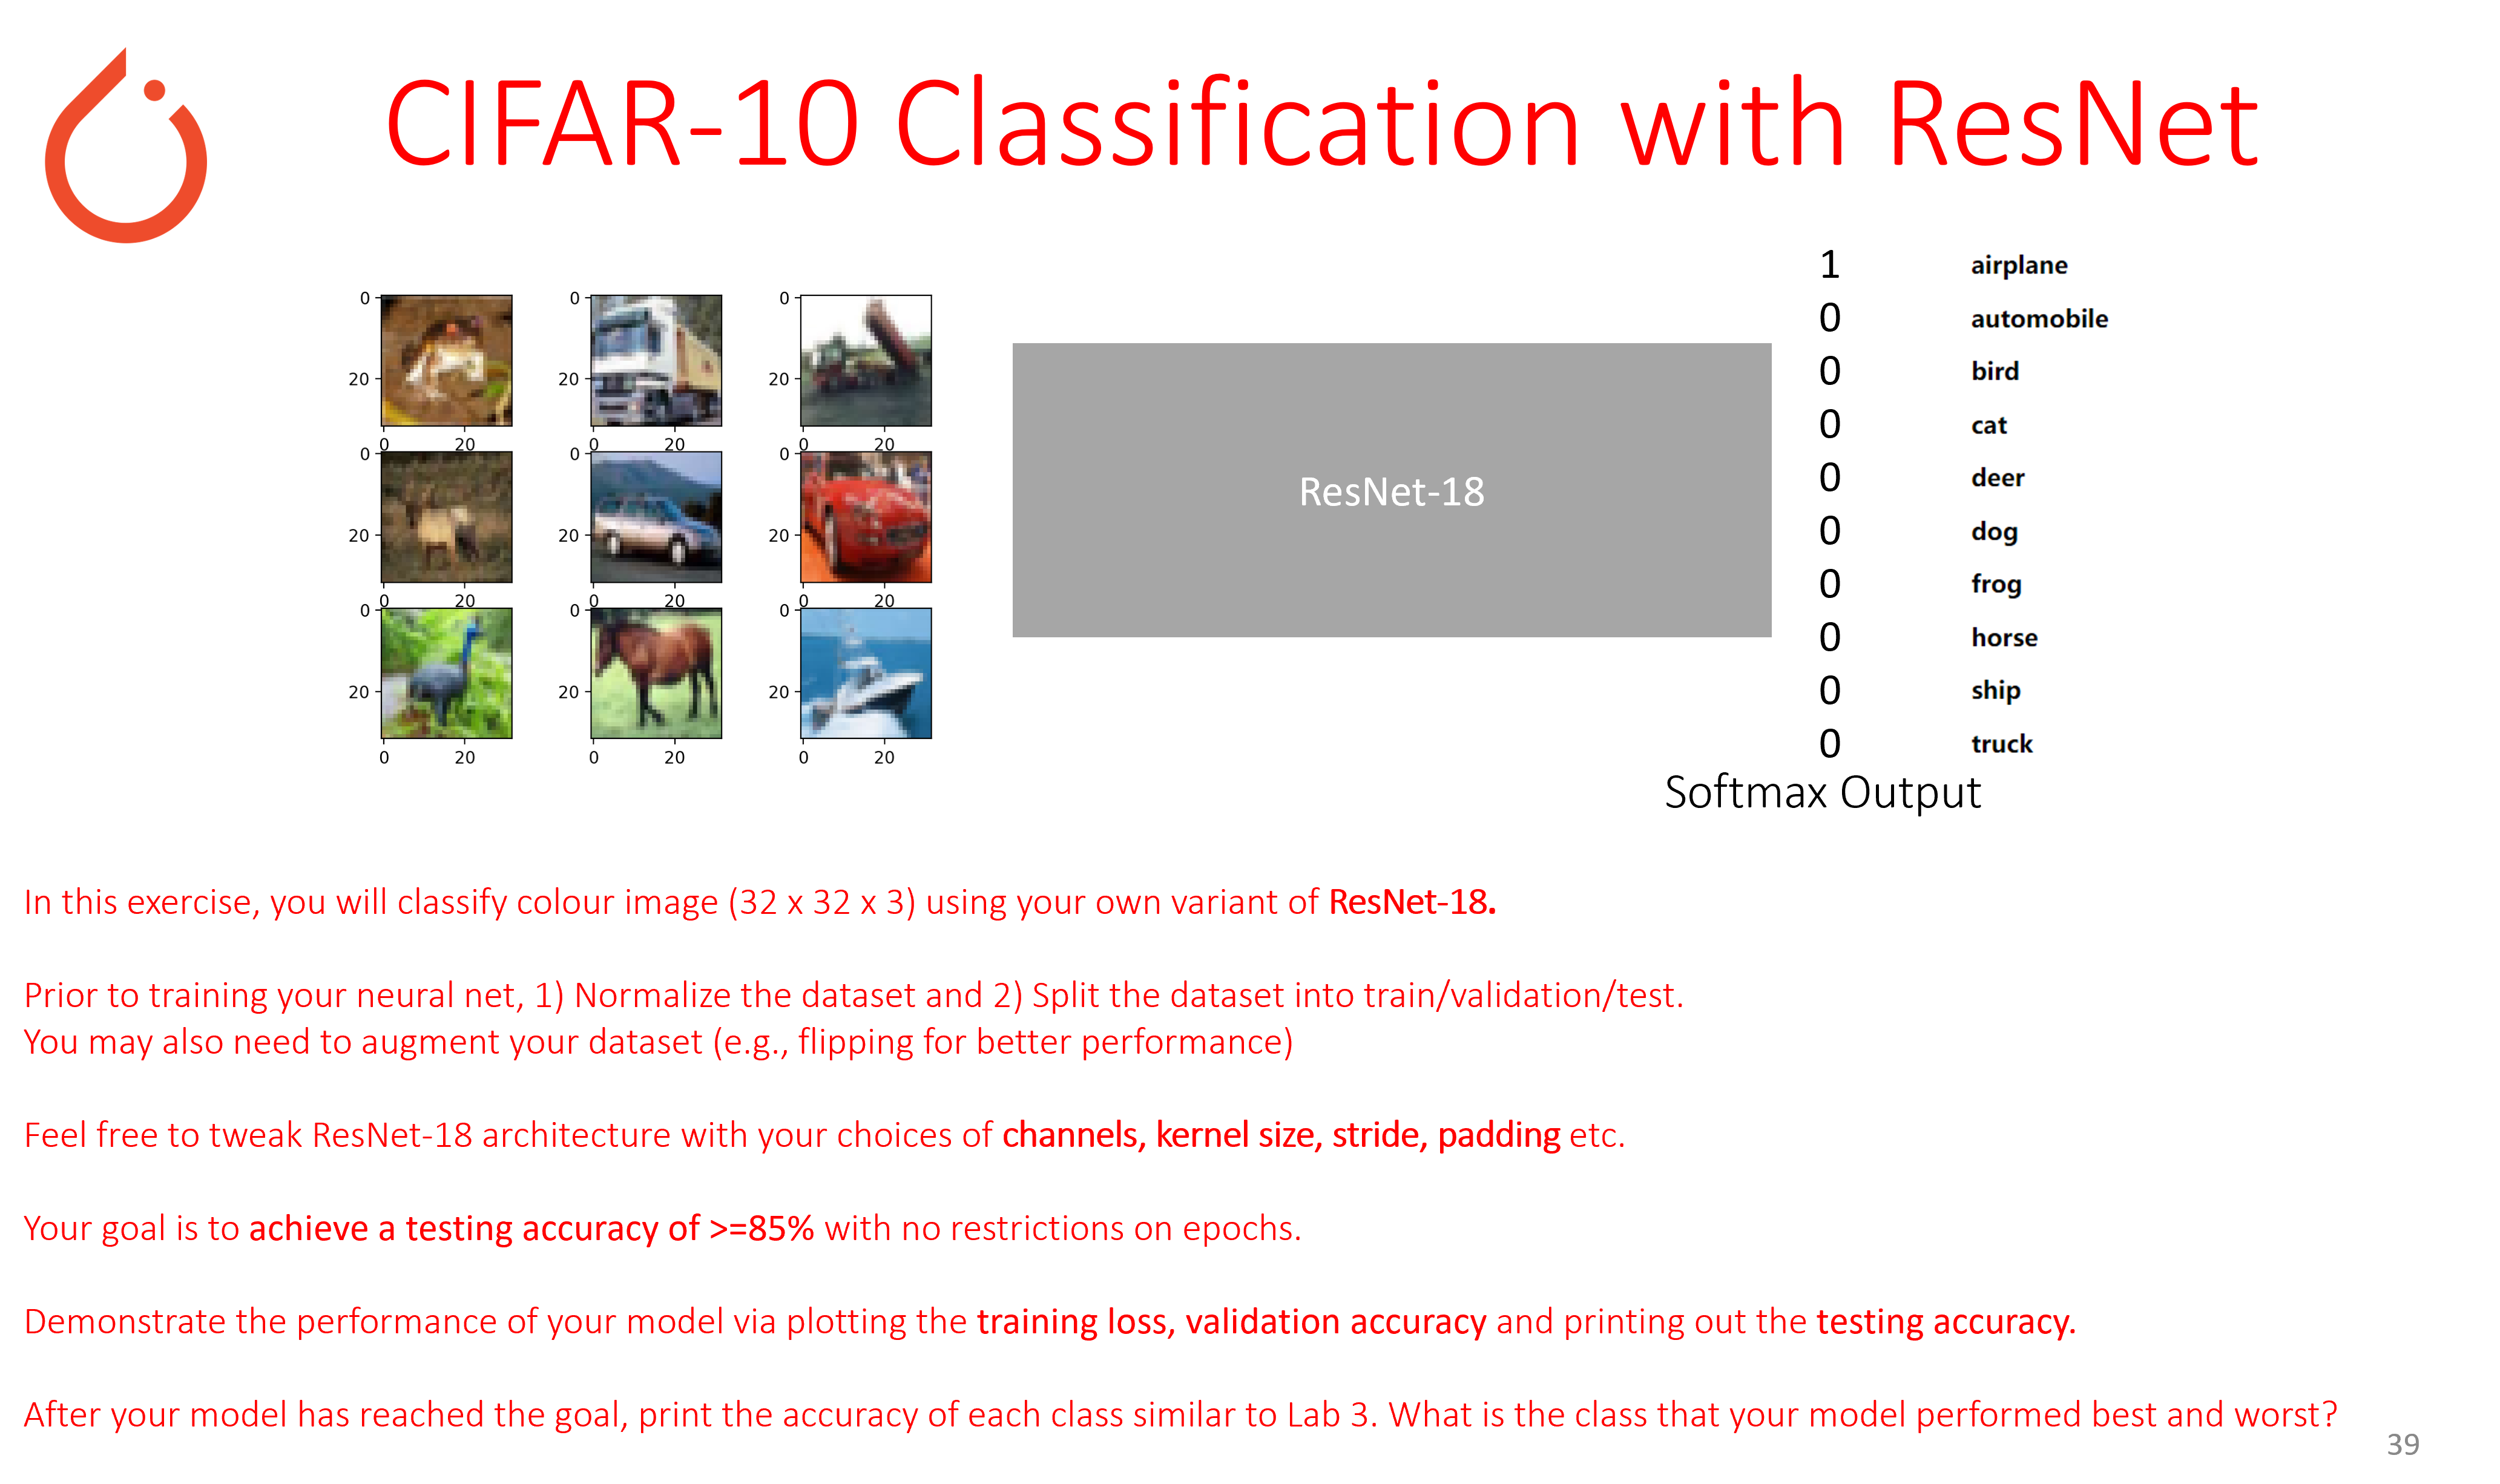

In [258]:
Image('lab7_exercise.png', width = 1000)

## Prepare Data

In [259]:
from torchvision import datasets, transforms

mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


## Define Model

In [260]:
from torchvision.models import resnet18

In [261]:
class Cifar_ResNet_Classifier(torch.nn.Module):
    
    def __init__(self, out_channels, kernel_size, stride, padding, num_fine_tune_layers=2):
        
        super(Cifar_ResNet_Classifier, self).__init__()

        self.resnet = resnet18(pretrained=True)

        # for param in self.resnet.parameters():
        #     param.requires_grad = False

        for i, child in enumerate(self.resnet.children()):
            if i < 8 - num_fine_tune_layers:
                for param in child.parameters():
                    param.requires_grad = False

        
        self.resnet.conv1 = torch.nn.Conv2d(in_channels=3, 
                                            out_channels=out_channels, 
                                            kernel_size=kernel_size, 
                                            stride=stride, 
                                            padding=padding, 
                                            bias=False)
        
        self.resnet.maxpool = torch.nn.Identity()
        
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

## Define Hyperparameters

In [262]:
# YOUR CODE HERE
classifier = Cifar_ResNet_Classifier(out_channels=64,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)

# Define learning rate and epochs
learning_rate = 1e-3      
epochs = 30

# Batch size for mini-batch gradient
batchsize = 128

# Using Adam as optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

classifier.to(device)

/Users/liambakar/anaconda3/envs/ee596/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/liambakar/anaconda3/envs/ee596/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Cifar_ResNet_Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tru

## Identify Tracked values

In [263]:
# YOUR CODE HERE
train_loss = []

## Train Model

In [264]:
# YOUR CODE HERE
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=False
)

In [265]:
print("Training on", device)

Training on mps


In [266]:
import tqdm

for epoch in range(epochs):
    
    for train_input, train_target in tqdm.tqdm(train_loader, desc="Training Batches"):
        
        optimizer.zero_grad()
        
        pred = classifier(train_input.to(device))
        
        loss = loss_func(pred, train_target.to(device))
        train_loss.append(loss.item())
        
        loss.backward()
        
        optimizer.step()
        
            
    print("Train Epoch: {} \tLoss: {:.6f}".format(epoch+1, loss.item()))
    scheduler.step()

Training Batches: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]


Train Epoch: 1 	Loss: 0.387387


Training Batches: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]


Train Epoch: 2 	Loss: 0.623283


Training Batches: 100%|██████████| 391/391 [01:02<00:00,  6.25it/s]


Train Epoch: 3 	Loss: 0.596180


Training Batches: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]


Train Epoch: 4 	Loss: 0.500470


Training Batches: 100%|██████████| 391/391 [01:02<00:00,  6.28it/s]


Train Epoch: 5 	Loss: 0.186426


Training Batches: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]


Train Epoch: 6 	Loss: 0.358854


Training Batches: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]


Train Epoch: 7 	Loss: 0.376532


Training Batches: 100%|██████████| 391/391 [01:18<00:00,  4.96it/s]


Train Epoch: 8 	Loss: 0.288345


Training Batches: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]


Train Epoch: 9 	Loss: 0.354524


Training Batches: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]


Train Epoch: 10 	Loss: 0.316754


Training Batches: 100%|██████████| 391/391 [01:02<00:00,  6.28it/s]


Train Epoch: 11 	Loss: 0.259949


Training Batches: 100%|██████████| 391/391 [01:33<00:00,  4.19it/s]


Train Epoch: 12 	Loss: 0.063080


Training Batches: 100%|██████████| 391/391 [04:44<00:00,  1.37it/s]  


Train Epoch: 13 	Loss: 0.236091


Training Batches: 100%|██████████| 391/391 [05:05<00:00,  1.28it/s] 


Train Epoch: 14 	Loss: 0.058196


Training Batches: 100%|██████████| 391/391 [04:04<00:00,  1.60it/s]


Train Epoch: 15 	Loss: 0.033906


Training Batches: 100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Train Epoch: 16 	Loss: 0.047025


Training Batches: 100%|██████████| 391/391 [05:06<00:00,  1.28it/s]


Train Epoch: 17 	Loss: 0.039995


Training Batches: 100%|██████████| 391/391 [05:35<00:00,  1.16it/s]  


Train Epoch: 18 	Loss: 0.110526


Training Batches: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]  


Train Epoch: 19 	Loss: 0.025789


Training Batches: 100%|██████████| 391/391 [02:03<00:00,  3.18it/s]


Train Epoch: 20 	Loss: 0.081359


Training Batches: 100%|██████████| 391/391 [02:14<00:00,  2.90it/s] 


Train Epoch: 21 	Loss: 0.031382


Training Batches: 100%|██████████| 391/391 [02:14<00:00,  2.91it/s]


Train Epoch: 22 	Loss: 0.043517


Training Batches: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


Train Epoch: 23 	Loss: 0.091991


Training Batches: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]


Train Epoch: 24 	Loss: 0.031205


Training Batches: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s] 


Train Epoch: 25 	Loss: 0.022989


Training Batches: 100%|██████████| 391/391 [01:31<00:00,  4.25it/s]


Train Epoch: 26 	Loss: 0.031442


Training Batches: 100%|██████████| 391/391 [03:12<00:00,  2.04it/s]


Train Epoch: 27 	Loss: 0.016010


Training Batches: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]


Train Epoch: 28 	Loss: 0.075865


Training Batches: 100%|██████████| 391/391 [02:17<00:00,  2.84it/s]


Train Epoch: 29 	Loss: 0.042219


Training Batches: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]


Train Epoch: 30 	Loss: 0.008895


## Visualize and Evaluate Model

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

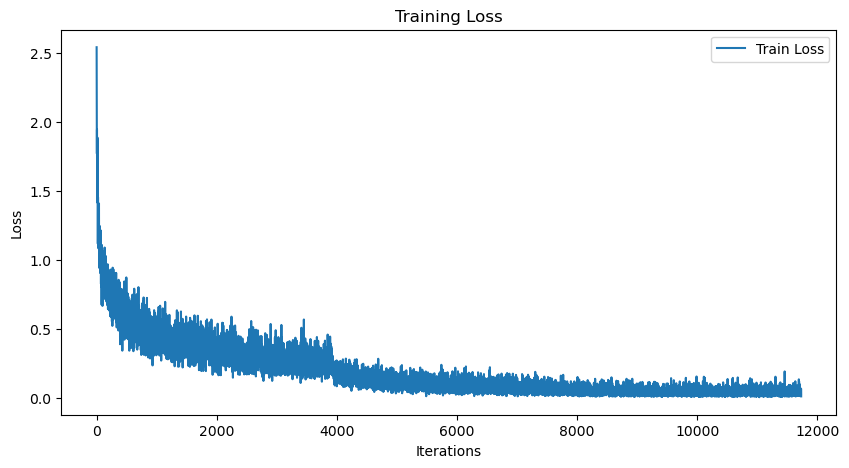

In [268]:
# YOUR CODE HERE
plt.figure(figsize=(10, 5))
plt.title("Training Loss")
plt.plot(train_loss, label="Train Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [269]:
# Print out the accuracy for each class. Which class performed the best and worst?
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()
    return 100 * correct / total

In [270]:
accuracy = test_model(classifier, test_loader)
print(f"Accuracy of the model on the test set: {accuracy:.2f}%")

Accuracy of the model on the test set: 92.46%


In [271]:
def test_model_per_class(model, test_loader):
    model.eval()
    correct = [0] * 10
    total = [0] * 10
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                total[labels[i]] += 1
                if predicted[i].cpu() == labels[i]:
                    correct[labels[i]] += 1
    return [c / t * 100 for c, t in zip(correct, total)]


In [272]:
per_class_accuracy = test_model_per_class(classifier, test_loader)
print("Accuracy per class:")
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i, class_name in enumerate(classes):
    print(f"{class_name}: {per_class_accuracy[i]:.2f}%")

Accuracy per class:
plane: 93.90%
car: 95.20%
bird: 91.40%
cat: 83.10%
deer: 93.50%
dog: 86.70%
frog: 95.70%
horse: 95.10%
ship: 95.00%
truck: 95.00%


In [273]:
best_class = classes[np.argmax(per_class_accuracy)]
worst_class = classes[np.argmin(per_class_accuracy)]
print(f"Best class: {best_class}")
print(f"Worst class: {worst_class}")

Best class: frog
Worst class: cat


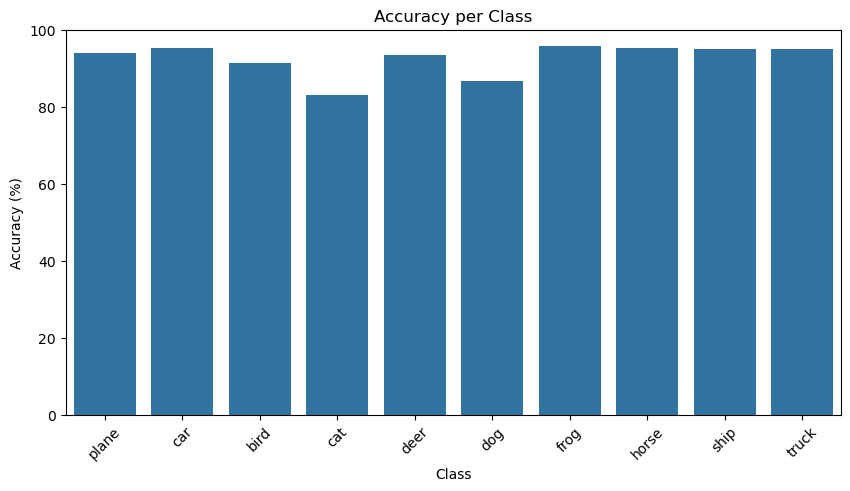

In [274]:
plt.figure(figsize=(10, 5))
sns.barplot(x=classes, y=per_class_accuracy)
plt.title("Accuracy per Class")
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()